The equation of the motion of the quadrotor is as follows

\begin{equation}
\begin{aligned}
\ddot{\phi} & = \dot{\theta}\dot{\psi}\left(\frac{I_y-I_z}{I_x}\right) - \frac{J_r}{I_x}\dot{\theta}\Omega + \frac{l}{I_x}U_2\\
\ddot{\theta} & = \dot{\phi}\dot{\psi}\left(\frac{I_z-I_x}{I_y}\right) + \frac{J_r}{I_y}\dot{\phi}\Omega + \frac{l}{I_y}U_3\\
\ddot{\psi} & = \dot{\phi}\dot{\theta}\left(\frac{I_x-I_y}{I_z}\right) + \frac{1}{I_z}U_4\\
\ddot{z} & = -g + (cos \phi cos \theta)\frac{1}{m}U_1 \\
\ddot{x} & = (\cos \phi \sin \theta \cos \psi + \sin \phi \sin \psi)\frac{1}{m}U_1 \\
\ddot{y} & = (\cos \phi \sin \theta \sin \psi - \sin \phi \cos \psi)\frac{1}{m}U_1 \\
\end{aligned}
\end{equation}

And the forces given the rotor rotation speeds are

\begin{equation}
\begin{aligned}
U_1 &= b(\Omega_1^2 + \Omega_2^2 + \Omega_3^2 + \Omega_4^2) \\
U_2 &= b(\Omega_4^2 - \Omega_2^2) \\
U_3 &= b(\Omega_3^2 - \Omega_1^2) \\
U_4 &= d(\Omega_2^2 + \Omega_4^2 - \Omega_1^2 - \Omega_3^2) \\
\Omega &= \Omega_2 + \Omega_4 - \Omega_1 - \Omega_3
\end{aligned}
\end{equation}




In [55]:
import numpy as np

I_x = 0.004 # KgM^2
I_y = 0.004 # KgM^2
I_z = 0.008 # KgM^2
J_r = 0.0003 # KgM^2
m = 0.500 # Kg
l = 0.25  # m
b = 3e-5  # Ns^2
d = 3e-7  # NMs^2
g = 9.81  #Ms^2

ACT_MAT = np.array([[b, b, b, b],[0, -b, 0, b],[-b, 0, b, 0],[-d, d, -d, d]], dtype=np.float64)
INV_ACT_MAT = np.linalg.inv(ACT_MAT)



U_1_eq = 0.5*g  # N

# The paremeters are from DUAL NEURAL NETWORK FOR ADAPTIVE SLIDING MODE CONTROL OF QUADROTOR HELICOPTER STABILIZATION


p_rot = 1
d_rot = 1




def body_angle_controls(state, t, angle_tgt):
    
    dot_phi, dot_theta, dot_psi, phi, theta, psi, dot_z, dot_x, dot_y, z, x, y  = state
    
    phi_tgt, theta_tgt, psi_tgt = angle_tgt
    
    
    U2 = p_rot*(phi_tgt - phi)     + d_rot*(0-dot_phi)
    U3 = p_rot*(theta_tgt- theta  ) + d_rot*(0-dot_theta)
    U4 = p_rot*( psi_tgt - psi)     + d_rot*(0-dot_psi)
    
    return U2, U3, U4



def determine_Omega_given_U(U_1, U_2, U_3, U_4):
    
    Omegas_sq = np.dot(INV_ACT_MAT, np.array([[U_1],[U_2],[U_3],[U_4]]))
    Omegas_sq = np.clip(Omegas_sq, 0, np.inf)
    Omegas = np.sqrt(Omegas_sq)
    Omega_sq = Omegas**2
    
    U = np.dot(ACT_MAT,Omega_sq) 
    
    Omega = Omegas[1] + Omegas[3] - Omegas[0] - Omegas[2]
    
    return U, Omega



def quad(state, t):
    dot_phi, dot_theta, dot_psi, phi, theta, psi, dot_z, dot_x, dot_y, z, x, y  = state
    
    # control start #
    angle_tgt = (0.1, 0.2, 0.3)
    
    U2_ctr, U3_ctr, U4_ctr = body_angle_controls(state, t, angle_tgt)
    
    # The forces
    U_1_tgt = U_1_eq 
    U_2_tgt = U2_ctr
    U_3_tgt = U3_ctr
    U_4_tgt = U4_ctr
    
    U, Omega = determine_Omega_given_U(U_1_tgt, U_2_tgt, U_3_tgt, U_4_tgt)
    
    
    #Omega = 0
    # control ends #
    
    ddot_phi   = dot_theta * dot_psi   * (I_y-I_z)/I_x - J_r/I_x*dot_theta* Omega + l/I_x*U[1]
    ddot_theta = dot_phi   * dot_psi   * (I_z-I_x)/I_y + J_r/I_y*dot_phi*   Omega + l/I_y*U[2]
    ddot_psi   = dot_phi   * dot_theta * (I_x-I_y)/I_z                            + 1/I_z*U[3]
    
    ddot_z = -g + np.cos(phi)*np.cos(theta)/m*U[0]
    ddot_x = (np.cos(phi)*np.sin(theta)*np.cos(psi)+np.sin(phi)*np.sin(psi))/m*U[0]
    ddot_y = (np.cos(phi)*np.sin(theta)*np.sin(psi)-np.sin(phi)*np.cos(psi))/m*U[0]
    
    d_state_dt = [ddot_phi, ddot_theta, ddot_psi, dot_phi, dot_theta, dot_psi, ddot_z, ddot_x, ddot_y, dot_z, dot_x, dot_y]
    
    return d_state_dt


state0 = [0,0,0,0,0,0,0,0,0,0,0,0]

t = np.linspace(0, 10, 10000)



from scipy.integrate import odeint
sol = odeint(quad, state0, t)


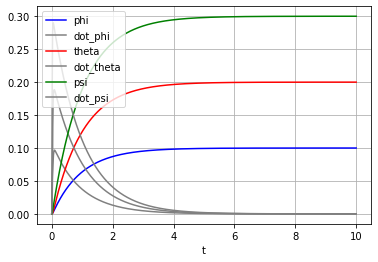

In [56]:
import matplotlib.pyplot as plt

plt.plot(t, sol[:, 3], 'b', label='phi')
plt.plot(t, sol[:, 0], 'grey', label='dot_phi')
plt.plot(t, sol[:, 4], 'r', label='theta')
plt.plot(t, sol[:, 1], 'grey', label='dot_theta')
plt.plot(t, sol[:, 5], 'g', label='psi')
plt.plot(t, sol[:, 2], 'grey', label='dot_psi')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()
